# Summary

This notebook will demnostrate one of the qualitative analyses made for CoGE on `REDDIT-BINARY` dataset. We will train a GIN model on the dataset and use our contrastive approach to explain the classification.

# Training a GIN Model
The model and training code is ported from [DGL GIN Example](https://github.com/dmlc/dgl/tree/master/examples/pytorch/gin)

In [1]:
import sys
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from dgl.data.gindt import GINDataset
from dataloader import GraphDataLoader, collate
from gin import GIN
from geomloss import SamplesLoss
from matplotlib import pyplot as plt
import random
import networkx as nx

Using backend: pytorch


In [2]:
class DummyArgs:
    pass

args = DummyArgs()
args.batch_size = 32
args.dataset = 'REDDITBINARY'
args.degree_as_tag = False
args.device = 0
args.disable_cuda = False
args.epochs = 350
args.filename = ''
args.final_dropout = 0.5
args.fold_idx=0
args.graph_pooling_type='sum'
args.hidden_dim=64
args.learn_eps=False
args.lr=0.01
args.neighbor_pooling_type='sum'
args.net='gin'
args.num_layers=5
args.num_mlp_layers=2
args.seed=0

In [3]:
def train(args, net, trainloader, optimizer, criterion, epoch):
    net.train()

    running_loss = 0
    total_iters = len(trainloader)

    for graphs, labels in trainloader:
        # batch graphs will be shipped to device in forward part of model
        labels = labels.to(args.device)
        feat = graphs.ndata.pop('attr').to(args.device)
        graphs = graphs.to(args.device)
        outputs = net(graphs, feat)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # the final batch will be aligned
    running_loss = running_loss / total_iters

    return running_loss


def eval_net(args, net, dataloader, criterion):
    net.eval()

    total = 0
    total_loss = 0
    total_correct = 0

    for data in dataloader:
        graphs, labels = data
        feat = graphs.ndata.pop('attr').to(args.device)
        graphs = graphs.to(args.device)
        labels = labels.to(args.device)
        total += len(labels)
        outputs = net(graphs, feat)
        _, predicted = torch.max(outputs.data, 1)

        total_correct += (predicted == labels.data).sum().item()
        loss = criterion(outputs, labels)
        # crossentropy(reduce=True) for default
        total_loss += loss.item() * len(labels)

    loss, acc = 1.0*total_loss / total, 1.0*total_correct / total

    net.train()

    return loss, acc


In [4]:
torch.manual_seed(seed=0)
np.random.seed(seed=0)

is_cuda = not args.disable_cuda and torch.cuda.is_available()

if is_cuda:
    args.device = torch.device("cuda:" + str(args.device))
    torch.cuda.manual_seed_all(seed=0)
else:
    args.device = torch.device("cpu")

## Load the dataset, this will take ~10 minutes for the first time

In [5]:
dataset = GINDataset(args.dataset, not args.learn_eps, degree_as_nlabel=True, verbose=True)

Done loading data from cached files.


In [6]:
trainloader, validloader = GraphDataLoader(
    dataset, batch_size=args.batch_size, device=args.device,
    collate_fn=collate, seed=args.seed, shuffle=True,
    split_name='fold10', fold_idx=args.fold_idx).train_valid_loader()

train_set : test_set = %d : %d 1800 200


In [7]:
model = GIN(
    args.num_layers, args.num_mlp_layers,
    dataset.dim_nfeats, args.hidden_dim, dataset.gclasses,
    args.final_dropout, args.learn_eps,
    args.graph_pooling_type, args.neighbor_pooling_type).to(args.device)

criterion = nn.CrossEntropyLoss()

## Train the GIN model

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

tbar = tqdm(range(args.epochs), unit="epoch")

for epoch in tbar:
    scheduler.step()

    train(args, model, trainloader, optimizer, criterion, epoch)

    train_loss, train_acc = eval_net(
        args, model, trainloader, criterion)
    print(
        'train set - average loss: {:.4f}, accuracy: {:.0f}%'
        .format(train_loss, 100. * train_acc))

    valid_loss, valid_acc = eval_net(
        args, model, validloader, criterion)
    print('valid set - average loss: {:.4f}, accuracy: {:.0f}%'.format(valid_loss, 100. * valid_acc))

    if not args.filename == "":
        with open(args.filename, 'a') as f:
            f.write('%s %s %s %s' % (
                args.dataset,
                args.learn_eps,
                args.neighbor_pooling_type,
                args.graph_pooling_type
            ))
            f.write("\n")
            f.write("%f %f %f %f" % (
                train_loss,
                train_acc,
                valid_loss,
                valid_acc
            ))
            f.write("\n")

    print(
        "Learning eps with learn_eps={}: {}".format(
            args.learn_eps, [layer.eps.data.item() for layer in model.ginlayers]))

In [10]:
model.eval()
torch.save(model.state_dict(),args.dataset + '.model')

## Or load a trained model
A trained model exists in the git repo

In [10]:
model.load_state_dict(torch.load(args.dataset + '.model',map_location=args.device))
model.eval()
print('model loaded')

model loaded


In [11]:
valid_loss, valid_acc = eval_net(args, model, validloader, criterion)
print('validation set - average loss: {:.4f}, accuracy: {:.0f}%'.format(valid_loss, 100. * valid_acc))

validation set - average loss: 0.2620, accuracy: 92%


# Explaining the model
## Save the model prediction for all samples

In [12]:
pred_labels = []
for g,_ in tqdm(dataset):
    pred_labels.append(model(g.to(args.device),torch.tensor(g.ndata['attr'].numpy(),dtype=torch.float32).to(args.device)).argmax().item())

In [13]:
import torch.nn.functional as F
def node_embeddings(model,g, from_layer=0, to_layer=None, concat=True):
    """
    This function runs the graph through the convolution layer but not the final pooling layer in order to
    extract node embeddings
    """
    h = torch.tensor(g.ndata['attr'].numpy(),dtype=torch.float32).to(args.device)
    hidden_rep = [h.cpu().detach().numpy()]

    for i in range(model.num_layers - 1):
        h = model.ginlayers[i](g.to(args.device), h)
        h = model.batch_norms[i](h)
        h = F.relu(h)
        hidden_rep.append(h.cpu().detach().numpy())
    embeddings = hidden_rep[from_layer:to_layer]
    if concat:
        embeddings = np.concatenate(embeddings,axis=1)
    return embeddings

## Compute node embeddings for all samples since they will be used multiple times in the future

In [14]:
cache_node_embeddings = {}
for i in tqdm(range(len(dataset))):
    cache_node_embeddings[i] = node_embeddings(model, dataset[i][0])

In [15]:
distance = SamplesLoss("sinkhorn", p=1, blur=.01)
try:
    dist_cache
except NameError as e:
    dist_cache = dict()

def graph_distance(g1_num, g2_num):
    """
    Memoized distance function for two graphs based on their ids
    """
    k = (min(g1_num, g2_num), max(g1_num, g2_num))
    if k in dist_cache:
        return dist_cache[k]
    g1_embs = cache_node_embeddings[g1_num]
    g2_embs = cache_node_embeddings[g2_num]
    try:
        dist_cache[k] = distance(torch.Tensor(g1_embs),torch.Tensor(g2_embs)).item()
    except:
        dist_cache[k] = 0
    return dist_cache[k]


In [16]:
def closest(cur_index, dist, size=1, neg_label = None, subsample = 1.):
    """
    Returns the ids of the most similar graphs with the same label and different labels as pair of arrays
    """
    cur_label = dataset[cur_index][1]
    # if pred_labels[cur_index]!=cur_label:
    #     print('Misclassified!')
    #     return None
    pos_dists = []
    neg_dists = []
    for i in tqdm(range(len(dataset))):
        if random.random() > subsample:
            continue
        if i==cur_index:
            continue
        if pred_labels[i] != dataset[i][1]: # ignore those not predicted correct
            continue
        d = dist(cur_index,i)
        if pred_labels[i] != cur_label:
            if neg_label is None or pred_labels[i] == neg_label:
                neg_dists.append((d,i))
        else:
            pos_dists.append((d,i))
    pos_dists = sorted(pos_dists)
    neg_dists = sorted(neg_dists)
    pos_indices = [i for d,i in pos_dists]
    neg_indices = [i for d,i in neg_dists]
    
    return pos_indices[:size], neg_indices[:size]

## Change the graph id to see explanations for different graphs

In [49]:
sample_graph_id = 1330

sample_graph = dataset[sample_graph_id][0]

sample_graph_embs = torch.Tensor(node_embeddings(model, sample_graph))

In [52]:
positive_ids, negative_ids = closest(sample_graph_id, graph_distance,size=10,subsample=0.1)

In [53]:
positive_samples_tensors = [torch.Tensor(cache_node_embeddings[i]) for i in positive_ids]
negative_samples_tensors = [torch.Tensor(cache_node_embeddings[i]) for i in negative_ids]

In [54]:
node_mask = torch.nn.Parameter(torch.zeros((sample_graph.number_of_nodes())))

## Learning the mask for minimizing the loss function

In [55]:
learning_rate = 1e-2
distance = SamplesLoss("sinkhorn", p=1, blur=.01)
optimizer = torch.optim.Adam([node_mask], lr=learning_rate)

def mydist(mask, embs):
    return distance(mask.softmax(0),sample_graph_embs,
                    distance.generate_weights(embs),embs)

tq = tqdm(range(50))
history = []
for t in tq:
    loss_pos = torch.mean(torch.stack([mydist(node_mask, x) for x in positive_samples_tensors]))
    loss_neg = torch.mean(torch.stack([mydist(node_mask, x) for x in negative_samples_tensors]))
    loss_self = mydist(node_mask, sample_graph_embs)

    loss = loss_neg - loss_pos + loss_self
    loss_str = 'loss_neg - loss_pos + loss_self'
    
    # You can change the loss function by uncommenting the following sections
#     loss = loss_neg + loss_self
#     loss_str = 'loss_neg + loss_self'

#     loss = loss_neg - loss_pos
#     loss_str = 'loss_neg - loss_pos'

#     loss = loss_neg
#     loss_str = 'loss_neg'

    hist_item = dict(loss_neg=loss_neg.item(),loss_self=loss_self.item(), loss_pos=loss_pos.item(),loss=loss.item())
    history.append(hist_item)
    if t % 100 == 0:
        print(t, loss.item())
    tq.set_postfix(**hist_item)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.7591584920883179



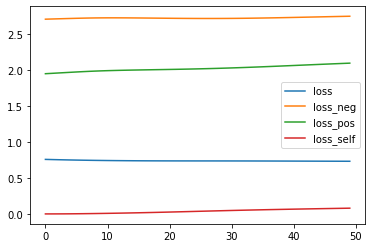

In [56]:
xaxis = list(range(len(history)))
for k in ['loss','loss_neg','loss_pos','loss_self']:
    plt.plot(xaxis, [x[k] for x in history],label=k)
plt.legend()
plt.show()

In [57]:
node_color = list(1 - node_mask.softmax(0).detach().numpy().ravel())

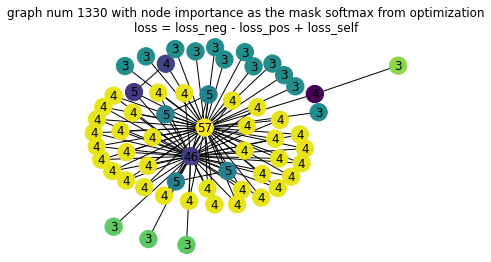

In [58]:
plt.title('graph num %d with node importance as the mask softmax from optimization\n' \
'loss = %s' % (sample_graph_id, loss_str))
g = sample_graph.to_networkx().to_undirected()
g_pos = nx.kamada_kawai_layout(g)
nx.draw(g,pos=g_pos, with_labels=True,node_color=node_color,labels=dict(g.degree()))